In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = '/home/paperspace/fastai/courses/dl1/data/dogscats/'
sz = 224

make sure both following returns True, meaning a working NVidia GPU set up.

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

In [6]:
os.listdir(PATH)

['sample', 'valid', 'models', 'train', 'tmp', 'test1']

In [7]:
os.listdir(f'{PATH}valid')

['cats', 'dogs']

In [8]:
files = os.listdir(f'{PATH}valid/cats')[:5]
files

['cat.11341.jpg',
 'cat.3869.jpg',
 'cat.5089.jpg',
 'cat.7380.jpg',
 'cat.11409.jpg']

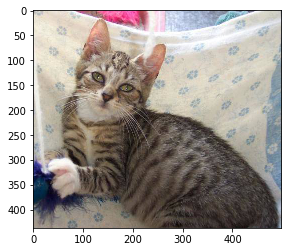

In [9]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img);

In [10]:
img.shape

(437, 499, 3)

In [11]:
img[:4,:4]

array([[[211, 211, 219],
        [210, 211, 216],
        [208, 207, 213],
        [202, 201, 206]],

       [[200, 201, 206],
        [199, 198, 204],
        [196, 195, 200],
        [193, 192, 197]],

       [[193, 192, 197],
        [189, 188, 193],
        [184, 183, 188],
        [185, 185, 187]],

       [[197, 195, 198],
        [189, 187, 190],
        [181, 179, 180],
        [183, 181, 182]]], dtype=uint8)

In [12]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.0471     0.029817   0.9905    
    1      0.04303    0.028436   0.989                        



[array([0.02844]), 0.989]

In [14]:
# This is the label for a val data
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [15]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

['cats', 'dogs']

In [16]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [17]:
log_preds[:10]

array([[ -0.00001, -11.23558],
       [ -0.00036,  -7.92678],
       [ -0.00019,  -8.55685],
       [ -0.0003 ,  -8.11455],
       [ -0.00012,  -8.98739],
       [ -0.00045,  -7.69867],
       [ -0.00005,  -9.9229 ],
       [ -0.00001, -11.73588],
       [ -0.0079 ,  -4.84465],
       [ -0.00016,  -8.74301]], dtype=float32)

In [18]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [19]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [20]:
lrf=learn.lr_find()

 82%|████████▏ | 294/360 [00:04<00:00, 71.93it/s, loss=0.465]


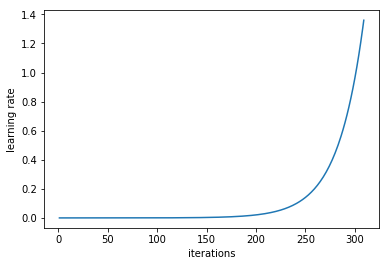

In [21]:
learn.sched.plot_lr()

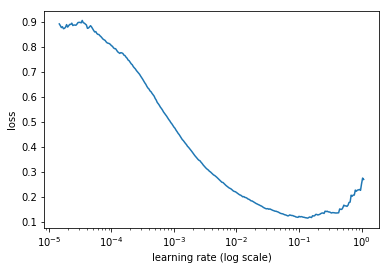

In [22]:
learn.sched.plot()

In [23]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [24]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [25]:
ims = np.stack([get_augs() for i in range(6)])

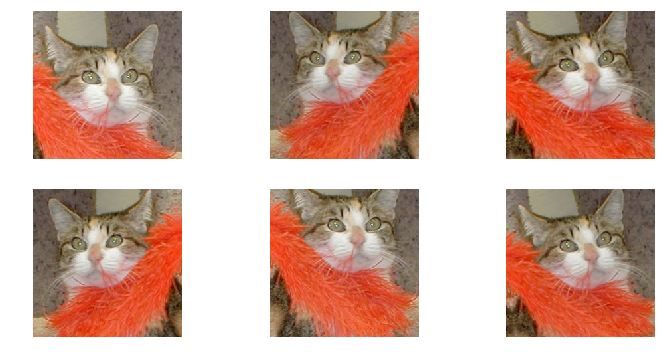

In [26]:
plots(ims, rows=2)

In [28]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [29]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.046581   0.028065   0.9905    



[array([0.02806]), 0.9905]

In [30]:
learn.precompute=False

In [31]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.0433     0.02857    0.9905    
    1      0.040431   0.027432   0.99                         
    2      0.044584   0.027233   0.9905                       



[array([0.02723]), 0.9905]

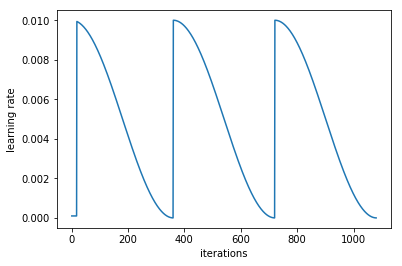

In [32]:
learn.sched.plot_lr()

In [34]:
learn.unfreeze()

In [35]:
lr=np.array([1e-4,1e-3,1e-2])

In [36]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.059417   0.029171   0.99      
    1      0.035959   0.025114   0.9895                       
    2      0.027101   0.022982   0.99                         
    3      0.029935   0.024544   0.99                         
    4      0.022802   0.019345   0.9925                       
    5      0.027783   0.019662   0.9905                       
    6      0.019219   0.020098   0.9925                       



[array([0.0201]), 0.9925]

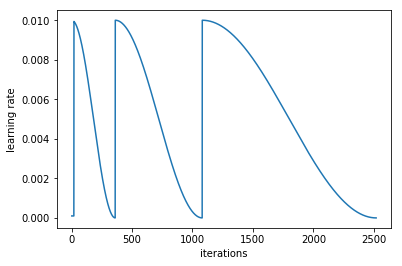

In [37]:
learn.sched.plot_lr()

In [38]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [39]:
accuracy_np(probs, y)

0.994

In [40]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [42]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[995   5]
 [  7 993]]


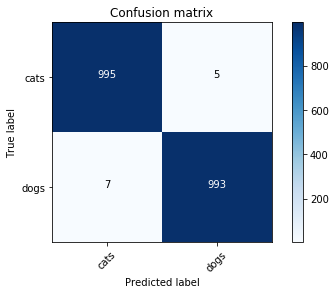

In [43]:
plot_confusion_matrix(cm, data.classes)

## Review: easy steps to train a world-class image classifier

1. Enable data augmentation, and precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

## Use resnext50

In [ ]:
# !wget http://files.fast.ai/models/weights.tgz
# !mkdir /usr/local/lib/python3.6/dist-packages/fastai/weights
# !tar -xvzf weights.tgz -C /usr/local/lib/python3.6/dist-packages/fastai/

In [3]:
PATH = '/home/paperspace/fastai/courses/dl1/data/dogscats/'
arch = resnext50
sz = 299
bs = 16

In [4]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [5]:
lrf = learn.lr_find()

 65%|██████▍   | 932/1438 [00:07<00:03, 128.63it/s, loss=0.231] 


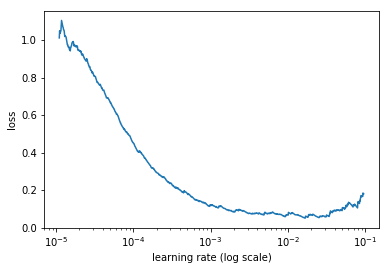

In [6]:
learn.sched.plot()

In [7]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                        
    0      0.059901   0.02522    0.9925    



[array([0.02522]), 0.9925]

In [8]:
learn.precompute = False
learn.fit(1e-2, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                       
    0      0.048877   0.02156    0.9925    
    1      0.060913   0.019773   0.9925                         



[array([0.01977]), 0.9925]

In [9]:
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])

In [18]:
learn.lr_find()

 36%|███▌      | 515/1438 [07:06<12:45,  1.21it/s, loss=0.0412] 

In [76]:
learn.sched.plot()

AttributeError: 'CosAnneal' object has no attribute 'plot'

In [10]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                       
    0      0.04363    0.019231   0.9925    
    1      0.048713   0.019265   0.992                          
    2      0.034012   0.015261   0.9945                         
    3      0.030535   0.018394   0.9925                         
    4      0.015736   0.017106   0.995                          
    5      0.012059   0.017644   0.9945                          
    6      0.011828   0.01533    0.9955                          



[array([0.01533]), 0.9955]

In [17]:
learn.save('299_bs_16_2')

In [11]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [12]:
accuracy_np(probs, y)

0.9955

In [13]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[994   6]
 [  3 997]]


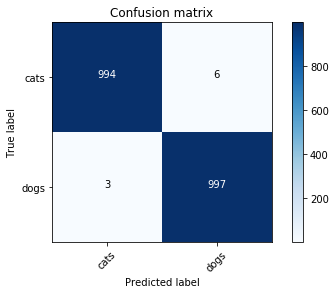

In [14]:
plot_confusion_matrix(cm, data.classes)

In [15]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

Most incorrect cats


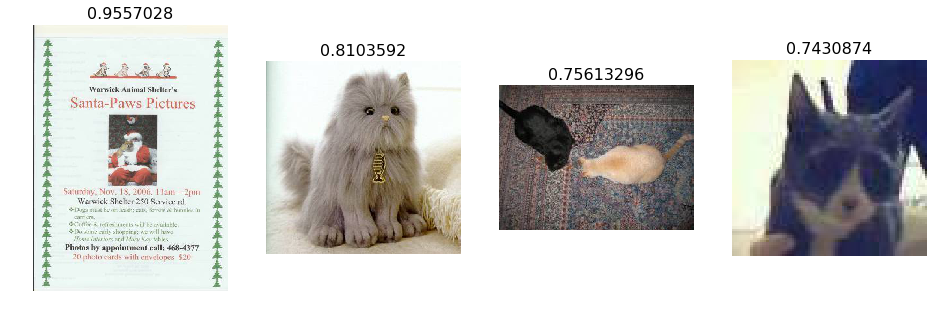

In [16]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


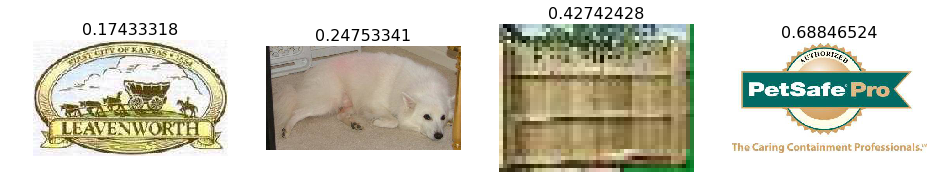

In [17]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

## Note:

- picking learning rate from learning rate finder: since naturally the decreass of loss will reduce when approaching the minimum point, the point where the loss decreasing fastest on the plot doesn't mean the best learning rate. better pick a point by backing up a little bit from the minimun point on the plot. So it's a point as big as possible, as long as the loss is still surely decreasing